In [1]:
import os
from collections import Counter

import numpy as np
import cv2

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import adam
from keras.regularizers import l2

from keras.utils import np_utils
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16, VGG19, Xception
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import metrics
from sklearn.utils import class_weight

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

### Data preparation

In [2]:
train_path = os.path.join("dataset", "training")
valid_path = os.path.join("dataset", "validation")
test_path = os.path.join("dataset", "test_new")
classes = os.listdir(train_path)
#classes = ['Apple Red Yellow', 'Apple Golden 1', 'Avocado', 'Avocado ripe', 'Banana',
#          'Cocos', 'Dates', 'Granadilla', 'Grape Pink', 'Grape White',
#          'Kiwi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes',
#          'Nectarine', 'Orange', 'Peach', 'Peach Flat', 'Apricot']
n_classes = len(classes)
print(n_classes)

90


In [3]:
print(classes)

['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Dates', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kiwi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mangostan', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach 2', 'Peach Flat', 'Pear', 'Pear Abate', 'Pear Monster', 'Pear Williams', 'Pepino', 'Physalis', 'Physalis with Husk

In [4]:
img_height, img_width, n_channels = 100, 100, 3

In [5]:
datagen = ImageDataGenerator(rescale=1. / 255,
                             rotation_range=100,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest')

In [6]:
train_generator =  datagen.flow_from_directory(
    train_path,
    classes=classes,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

Found 46486 images belonging to 90 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [8]:
valid_generator = test_datagen .flow_from_directory(
    valid_path,
    classes=classes,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

Found 7777 images belonging to 90 classes.


In [9]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    classes=classes,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical')

Found 7786 images belonging to 90 classes.


In [90]:
img = train_generator.next()
print(len(img))
print(img[0].shape)
print(img[1].shape)

2
(128, 100, 100, 3)
(128, 90)


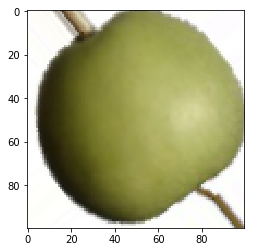

In [92]:
plt.imshow(img[0][1])

### Create class weights for imbalanced classes

In [10]:
y = train_generator.classes

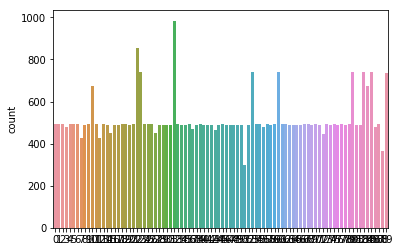

In [11]:
sns.countplot(y)

In [12]:
def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}


In [13]:
class_weights = get_class_weights(y)

In [14]:
sample_weights = class_weight.compute_sample_weight(class_weights, y)

In [15]:
sample_weights[50:]

array([2.        , 2.        , 2.        , ..., 1.33877551, 1.33877551,
       1.33877551])

### Model 1. Pretrained VGG16

In [16]:
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(img_width, img_height, n_channels))
vgg16_net.trainable = False 

In [17]:
vgg16_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [18]:
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv3':
        trainable = True
    layer.trainable = trainable    

In [19]:
vgg16_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [20]:
model = Sequential()

model.add(vgg16_net)
model.add(Flatten())

model.add(Dense(256, activation="relu",
                kernel_initializer="he_uniform",
                kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu",
                kernel_initializer="he_uniform",
                kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(n_classes, activation="softmax",
                kernel_initializer="glorot_uniform",
                kernel_regularizer=l2(0.01)))

model.compile(loss='categorical_crossentropy',
              #optimizer=adam(lr=1e-5),
              optimizer=adam(),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

In [21]:
#TensorBoard(log_dir="tb_logs", histogram_freq=1, write_images=True)
callbacks = [EarlyStopping(monitor="val_acc",
                           patience=4),
             ModelCheckpoint(os.path.join("logs",
                                          'model2_90classes.{epoch:02d}-{acc:.4f}.hdf5'),
                             save_best_only=True,
                             monitor="val_acc")]

In [27]:
%%time
history = model.fit_generator(train_generator, 
       epochs=50,                    
       validation_data=valid_generator,
       callbacks=callbacks,
       class_weight=class_weights,                  
       verbose=1)

Epoch 1/50
364/364 [==============================] - 1207s 3s/step - loss: 1.4635 - acc: 0.9351 - val_loss: 1.4023 - val_acc: 0.8233
Epoch 2/50
364/364 [==============================] - 652s 2s/step - loss: 1.0678 - acc: 0.9571 - val_loss: 1.0998 - val_acc: 0.8658
Epoch 3/50
364/364 [==============================] - 652s 2s/step - loss: 0.9584 - acc: 0.9593 - val_loss: 0.7798 - val_acc: 0.9501
Epoch 4/50
364/364 [==============================] - 652s 2s/step - loss: 0.8252 - acc: 0.9650 - val_loss: 0.6987 - val_acc: 0.9481
Epoch 5/50
364/364 [==============================] - 652s 2s/step - loss: 0.7653 - acc: 0.9678 - val_loss: 0.6346 - val_acc: 0.9640
Epoch 6/50
364/364 [==============================] - 651s 2s/step - loss: 0.6929 - acc: 0.9709 - val_loss: 0.6487 - val_acc: 0.9416
Epoch 7/50
364/364 [==============================] - 652s 2s/step - loss: 0.6903 - acc: 0.9698 - val_loss: 0.9291 - val_acc: 0.8714
Epoch 8/50
364/364 [==============================] - 651s 2s/step -

#### optimizer=adam(lr=1e-5)

Epoch 1/50
364/364 [==============================] - 673s 2s/step - loss: 21.0599 - acc: 0.0353 - val_loss: 14.6992 - val_acc: 0.2002
Epoch 2/50
 65/364 [====>.........................] - ETA: 7:46 - loss: 19.4347 - acc: 0.0713

In [28]:
%%time
scores = model.evaluate_generator(test_generator, verbose=1)
print("Test accuracy after last epoch =", scores[1])

61/61 [==============================] - 89s 1s/step
Test accuracy after last epoch = 0.956331877928297
Wall time: 1min 28s


time 128 = 100 s

time 32 = 104 s

time 64 = 97 s


In [29]:
model.save_weights("logs/model2.2_90classes_vgg16_weights.hdf5")

### Test saved model

In [32]:
# Load best 1 model
model.load_weights("logs/model2_90classes_0.98.hdf5")

In [37]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Test accuracy =", scores[1])

61/61 [==============================] - 90s 1s/step
Test accuracy = 0.982019008874832


model2_90classes_0.98 

Test accuracy = 0.9820190083695781

In [33]:
scores = model.evaluate_generator(valid_generator, verbose=1)
print("Valid accuracy =", scores[1])

61/61 [==============================] - 88s 1s/step
Valid accuracy = 0.9816124469513174


In [ ]:
scores = model.evaluate_generator(train_generator, verbose=1)
print("Train accuracy =", scores[1])

#### Save architecture

In [24]:
saved_model = model.to_json()
with open("logs/model2_90classes_architecture.json", "w") as json_file:
    json_file.write(saved_model)

### Continue tuning

In [25]:
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv2':
        trainable = True
    layer.trainable = trainable   

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer=adam(lr=1e-5),
              #optimizer=adam(),
              metrics=['accuracy'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

In [28]:
model.load_weights("logs/model2.2_90classes.hdf5")

In [36]:
%%time
history = model.fit_generator(train_generator, 
       epochs=1,                    
       validation_data=valid_generator,
       callbacks=callbacks,
       class_weight=class_weights,                  
       verbose=1)

Epoch 1/1
1453/1453 [==============================] - 898s 618ms/step - loss: 0.4427 - acc: 0.9889 - val_loss: 0.3892 - val_acc: 0.9883
Wall time: 14min 58s


In [37]:
%%time
scores = model.evaluate_generator(valid_generator, verbose=1)
print("Valid accuracy =", scores[1])

244/244 [==============================] - 98s 400ms/step
Valid accuracy = 0.9882988298829883
Wall time: 1min 37s


Valid accuracy = 0.9783978397686499

Valid accuracy = 0.9808409412216524

Valid accuracy = 0.9849556383979923 1 epoch

val_acc: 0.9856 2 epochs

Valid accuracy = 0.9882988298829883 3 epochs

In [38]:
%%time
scores = model.evaluate_generator(test_generator, verbose=1)
print("Test accuracy after last epoch =", scores[1])

244/244 [==============================] - 101s 412ms/step
Test accuracy after last epoch = 0.9895967120472643
Wall time: 1min 40s


0.9825327512907425

Test accuracy after last epoch = 0.9829180579457404

Test accuracy after last epoch = 0.9865142563575648 2 epochs

Test accuracy after last epoch = 0.9895967120472643 3 epochs

In [39]:
model.save_weights("logs/model2.2_90classes.hdf5")

In [40]:
saved_model = model.to_json()
with open("logs/model2.2_90classes_architecture.json", "w") as json_file:
    json_file.write(saved_model)

### Continue tuning 2

In [31]:
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv1' or \
        layer.name == 'block5_conv2' or \
        layer.name == 'block5_conv3' or \
        layer.name == 'block1_conv1':
        trainable = True
    layer.trainable = trainable   

In [32]:
vgg16_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [33]:
model.compile(loss='categorical_crossentropy',
              optimizer=adam(lr=1e-5),
              #optimizer=adam(),
              metrics=['accuracy'])

In [25]:
#model.load_weights("logs/model2.3_90classes.hdf5")
model.load_weights("logs/model2.4_90classes.hdf5")

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
__________

In [40]:
%%time
history = model.fit_generator(train_generator, 
       epochs=2,                    
       validation_data=valid_generator,
       callbacks=callbacks,
       class_weight=class_weights,                  
       verbose=1)

Epoch 1/2
1453/1453 [==============================] - 2089s 1s/step - loss: 0.3404 - acc: 0.9934 - val_loss: 0.3117 - val_acc: 0.9893
Epoch 2/2
1453/1453 [==============================] - 2088s 1s/step - loss: 0.3286 - acc: 0.9933 - val_loss: 0.2856 - val_acc: 0.9941
Wall time: 1h 9min 37s


In [41]:
%%time
scores = model.evaluate_generator(valid_generator, verbose=1)
print("Valid accuracy =", scores[1])

244/244 [==============================] - 98s 400ms/step
Valid accuracy = 0.9940851227979941
Wall time: 1min 37s


Valid accuracy = 0.9866272341519866 1 ep

model 2.4:

Valid accuracy = 0.9945994599459946 3 ep 2 h - saved

Valid accuracy = 0.9940851227979941 5 ep 3h 

In [42]:
%%time
scores = model.evaluate_generator(test_generator, verbose=1)
print("Test accuracy after last epoch =", scores[1])

244/244 [==============================] - 98s 401ms/step
Test accuracy after last epoch = 0.9962753660416132
Wall time: 1min 37s


Test accuracy after last epoch = 0.9886976624404805 1 ep

model 2.4:

Test accuracy after last epoch = 0.9961469303878757 3 ep - saved

Test accuracy after last epoch = 0.9962753660416132 5 ep

In [43]:
#model.save_weights("logs/model2.3_90classes.hdf5")
model.save_weights("logs/model2.4_90classes.hdf5")

In [44]:
#saved_model = model.to_json()
#with open("logs/model2.3_90classes_architecture.json", "w") as json_file:
#    json_file.write(saved_model)

saved_model = model.to_json()
with open("logs/model2.4_90classes_architecture.json", "w") as json_file:
    json_file.write(saved_model)

##### model 2.4:
Trainable layers of vgg16:

        layer.name == 'block5_conv1'
        layer.name == 'block5_conv2'
        layer.name == 'block5_conv3'
        layer.name == 'block1_conv1